In [ ]:
import os
os.chdir("..")

In [ ]:
from src.data.data_process import DataReg
import polars as pl
import requests
import geopandas as gpd
from pysal.lib import weights
from shapely import wkt
import pandas as pd
import arviz as az
import matplotlib.dates as mdates
import numpy as np
import causalpy as cp
import matplotlib.pyplot as plt
dr = DataReg()

In [ ]:
df_qcew = dr.base_data().with_columns(
    treatment=pl.when(pl.col("year") >= 2023).then(True).otherwise(False)
)
# df_dp03 = dr.pull_dp03()
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)

# df = df_qcew.join(df_dp03, on=["zipcode","year"], how="inner")
df = pr_zips.join(
    df_qcew.to_pandas().set_index("zipcode"), on="zipcode", how="inner", validate="1:m"
        ).reset_index(drop=True)
df = df.sort_values("year").reset_index(drop=True)
df

In [ ]:
sector_df = df[(df["sector"] == "61")].reset_index(drop=True)
y = sector_df["total_employment"].values.reshape(-1,1)
w = weights.distance.DistanceBand.from_dataframe(
    sector_df, 80467
)
reg = sector_df
reg["w_emplyment"] = weights.lag_spatial(w,y) 
reg

In [ ]:
# Assuming `reg` is your DataFrame and you want to set the 'year' column as a datetime index
data = reg.copy()
data = data.drop("geometry", axis=1)
data = data.drop("sector", axis=1)
data = data.drop("treatment", axis=1)
# Make sure the 'year' column is converted to datetime, assuming 'year' contains just the year (e.g., 2025)
data['year'] = pd.to_datetime(data['year'], format='%Y')

# Now set 'year' as the index and drop the 'year' column
data.index = data['year']
data = data.drop('year', axis=1)
data = data.drop("zipcode", axis=1)
data_grouped = data.groupby(data.index.year).mean()
data_grouped.index = pd.to_datetime(data_grouped.index, format='%Y')
data_grouped

In [ ]:
treatment_index = pd.to_datetime(2023, format='%Y')
model = cp.skl_models.WeightedProportion()
formula = 'total_employment ~ 0 + w_emplyment + k_index'

In [ ]:
results = cp.SyntheticControl(
data_grouped,
treatment_index,
formula=formula,
model=model,
)

In [ ]:
fig, ax = results.plot(plot_predictors=True)

In [ ]:
treatment_time = pd.to_datetime("2020-01-01")
result = cp.InterruptedTimeSeries(
    demeaned_data,
    treatment_time,
    formula="total_employment ~ 0 + k_index + total_employment",
    model=cp.pymc_models.LinearRegression(),
)

In [33]:
df = dr.conn.sql("SELECT first_month_employment, second_month_employment, third_month_employment, ui_addr_5_zip, qtr, year FROM qcewtable").pl()

In [34]:
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)
empty_df = [pl.Series("date", [], dtype=pl.String)]
for zips in list(pr_zips["zipcode"].values):
    empty_df.append(pl.Series(f"zip_{zips}", [], dtype=pl.Int32))
df_master = pl.DataFrame(empty_df)
df_master

tmp = df.drop_nulls()
tmp = tmp.filter(pl.col("ui_addr_5_zip").is_in(list(pr_zips["zipcode"].values)))
tmp  = tmp.group_by(["year", "qtr","ui_addr_5_zip"]).agg(
    first_month_employment = pl.col("first_month_employment").sum(),
    second_month_employment = pl.col("second_month_employment").sum(),
    third_month_employment = pl.col("third_month_employment").sum()
)

tmp = tmp.with_columns(
    ui_addr_5_zip="zip_" + pl.col("ui_addr_5_zip")
)

In [35]:
def foo(df:pl.DataFrame, year, qtr):
    df = df.filter((pl.col("year") == year) & (pl.col("qtr") == qtr))
    if df.is_empty():
        return df
    names = df.select(pl.col("ui_addr_5_zip")).transpose()
    names = names.to_dicts().pop()
    df = df.drop("year", "qtr", "ui_addr_5_zip").transpose(include_header=True)
    df = df.rename(names)
    df = df.with_columns(
        date=pl.when((qtr == 1) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-01-01"))
               .when((qtr == 1) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-02-01"))
               .when((qtr == 1) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-03-01"))
               .when((qtr == 2) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-04-01"))
               .when((qtr == 2) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-05-01"))
               .when((qtr == 2) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-06-01"))
               .when((qtr == 3) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-07-01"))
               .when((qtr == 3) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-08-01"))
               .when((qtr == 3) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-09-01"))
               .when((qtr == 4) & (pl.col("column") == "first_month_employment")).then(pl.lit(f"{year}-10-01"))
               .when((qtr == 4) & (pl.col("column") == "second_month_employment")).then(pl.lit(f"{year}-11-01"))
               .when((qtr == 4) & (pl.col("column") == "third_month_employment")).then(pl.lit(f"{year}-12-01"))
               .otherwise(pl.lit("ERROR"))
    )
    return df.drop("column")

In [36]:
for year in range(2002, 2025):
    for qtr in range(1,5):
        something = foo(tmp,year, qtr)
        if something.is_empty():
            print(year,qtr)
            continue
        df_master = pl.concat([df_master, something], how="diagonal")
df_master

2024 3
2024 4


date,zip_00791,zip_00769,zip_00667,zip_00953,zip_00612,zip_00777,zip_00690,zip_00754,zip_00631,zip_00611,zip_00720,zip_00707,zip_00723,zip_00647,zip_00901,zip_00692,zip_00956,zip_00950,zip_00745,zip_00741,zip_00913,zip_00917,zip_00921,zip_00983,zip_00961,zip_00982,zip_00638,zip_00637,zip_00783,zip_00653,zip_00907,zip_00603,zip_00912,zip_00976,zip_00736,zip_00909,…,zip_00766,zip_00678,zip_00918,zip_00927,zip_00728,zip_00656,zip_00662,zip_00682,zip_00714,zip_00674,zip_00616,zip_00795,zip_00727,zip_00725,zip_00729,zip_00924,zip_00773,zip_00767,zip_00794,zip_00669,zip_00602,zip_00622,zip_00920,zip_00979,zip_00646,zip_00771,zip_00784,zip_00925,zip_00985,zip_00969,zip_00952,zip_00850,zip_00830,zip_00802,zip_00851,zip_00820,zip_00840
str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
"""2002-01-01""",3736,2755,2124,653,2636,3524,1419,2421,350,107,1256,778,812,189,3594,1847,3709,4196,4139,330,483,4227,2052,915,2433,213,2527,1945,1610,956,13723,782,422,1061,1943,3432,…,788,1982,27340,10066,1135,1324,3629,419,1379,16996,76,2843,11,6982,2438,1472,1240,3900,1251,1937,4223,434,4665,3275,4722,4512,763,1912,627,4654,1353,null,null,35,null,null,null
"""2002-02-01""",3788,2811,2167,648,2615,3507,1280,2480,349,107,1241,799,832,186,3503,1808,3727,4168,4132,352,493,4375,2087,902,2434,215,2468,1959,1611,981,13907,780,420,1079,1922,3411,…,781,1971,27861,10082,1152,1257,3751,419,1363,16660,76,2817,14,6985,2452,1486,1289,3890,1270,1956,4118,440,4625,3318,4640,4632,764,1887,632,4643,1337,null,null,35,null,null,null
"""2002-03-01""",3803,2830,2167,660,2552,3612,1365,2396,356,108,1243,854,824,190,3330,1810,3775,4156,4129,375,499,4447,2067,896,2436,212,2525,1960,1636,965,14108,785,427,1085,2005,3481,…,806,1984,28126,10073,1074,1335,3741,413,1378,15307,75,2808,15,7002,2476,1486,1252,3891,1263,1951,4142,448,4639,3321,4663,4626,773,1896,647,4639,1374,null,null,35,null,null,null
"""2002-04-01""",3849,2764,2200,641,2577,3584,1365,2372,339,119,1258,887,792,174,3122,1906,3665,4130,4052,365,499,4708,1964,881,2418,213,2529,2077,1658,1006,14015,773,403,1114,1908,3460,…,733,1933,27102,9969,1003,1350,3669,409,1358,15410,76,2884,17,7027,2424,1477,1222,4179,1246,1893,3722,459,4477,3247,7282,4605,737,1851,603,4621,1433,null,null,30,null,null,null
"""2002-05-01""",3838,2702,2196,628,2619,3579,1260,2445,345,116,1281,907,811,173,2886,1932,3702,4185,4047,357,506,4739,1995,898,2447,210,2595,2044,1666,1118,14127,783,404,1142,1905,3423,…,738,1947,26539,9931,985,1326,3650,413,1349,15236,76,2853,17,7126,2481,1488,1237,4288,1270,1894,3711,461,4545,3280,7279,4628,746,1874,608,4835,1437,null,null,32,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-02-01""",4421,2393,3111,2232,5819,6282,547,2266,411,121,1761,577,1278,307,7118,2285,3889,11078,4158,604,205,8195,6897,1517,3689,720,1502,2471,3475,757,13687,2980,636,1595,1806,2902,…,1593,2058,11712,8922,1467,1166,5381,1417,1947,11368,164,4823,1465,12056,4157,1179,1348,2263,2362,4013,3880,846,3442,9837,8547,6683,1326,3674,996,13069,2927,null,null,14,3,null,0
"""2024-03-01""",4440,2442,3290,2312,5878,6426,544,2315,411,120,1797,596,1277,306,7189,2301,4001,11046,4151,622,197,8421,6936,1509,3696,711,1547,2539,3520,761,13863,3052,642,1625,1840,2977,…,1596,2110,11886,8925,1466,1169,5545,1440,1930,11496,163,4875,1465,12062,4141,1191,1370,2279,2378,4046,3965,884,3481,9941,8628,6922,1331,3738,996,13177,2933,null,null,14,3,null,0
"""2024-04-01""",4334,2434,3117,2282,5624,6360,538,2316,408,116,1778,594,1278,300,6907,2291,3819,11084,4173,638,197,8309,6886,1518,3737,715,1474,2466,3660,816,14338,2982,667,1640,1865,2935,…,1636,2086,11692,8920,1545,1385,5567,1382,1942,11654,166,4989,1321,1

In [41]:
data = df_master
columns_with_nulls = [col for col in data.columns if data[col].is_null().any()]

data = data.drop(columns_with_nulls)
data = data.to_pandas()
data["date"] = pd.to_datetime(data["date"])
treatment_time = pd.to_datetime("2023-01-01")
data.index = pd.to_datetime(data['date'])
data = data.drop('date', axis=1)
data

,zip_00791,zip_00769,zip_00667,zip_00953,zip_00612,zip_00777,zip_00690,zip_00754,zip_00631,zip_00611,...,zip_00622,zip_00920,zip_00979,zip_00646,zip_00771,zip_00784,zip_00925,zip_00985,zip_00969,zip_00952
date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,3736,2755,2124,653,2636,3524,1419,2421,350,107,...,434,4665,3275,4722,4512,763,1912,627,4654,1353
2002-02-01,3788,2811,2167,648,2615,3507,1280,2480,349,107,...,440,4625,3318,4640,4632,764,1887,632,4643,1337
2002-03-01,3803,2830,2167,660,2552,3612,1365,2396,356,108,...,448,4639,3321,4663,4626,773,1896,647,4639,1374
2002-04-01,3849,2764,2200,641,2577,3584,1365,2372,339,119,...,459,4477,3247,7282,4605,737,1851,603,4621,1433
2002-05-01,3838,2702,2196,628,2619,3579,1260,2445,345,116,...,461,4545,3280,7279,4628,746,1874,608,4835,1437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01,4421,2393,3111,2232,5819,6282,547,2266,411,121,...,846,3442,9837,8547,6683,1326,3674,996,13069,2927
2024-03-01,4440,2442,3290,2312,5878,6426,544,2315,411,120,...,884,3481,9941,8628,6922,1331,3738,996,13177,2933
2024-04-01,4334,2434,3117,2282,5624,6360,538,2316,408,116,...,886,3715,10062,8575,7094,1239,3784,995,13241,2770


In [45]:
formula = "zip_00690 ~ 0"
for col in data.columns:
    if col == "zip_00690":
        continue
    formula += f" + {col}"
formula

'zip_00690 ~ 0 + zip_00791 + zip_00769 + zip_00667 + zip_00953 + zip_00612 + zip_00777 + zip_00754 + zip_00631 + zip_00611 + zip_00720 + zip_00707 + zip_00723 + zip_00647 + zip_00901 + zip_00692 + zip_00956 + zip_00950 + zip_00745 + zip_00741 + zip_00913 + zip_00917 + zip_00921 + zip_00983 + zip_00961 + zip_00982 + zip_00638 + zip_00637 + zip_00783 + zip_00653 + zip_00907 + zip_00603 + zip_00912 + zip_00976 + zip_00736 + zip_00909 + zip_00934 + zip_00971 + zip_00716 + zip_00623 + zip_00765 + zip_00757 + zip_00664 + zip_00719 + zip_00606 + zip_00962 + zip_00926 + zip_00617 + zip_00693 + zip_00739 + zip_00911 + zip_00915 + zip_00987 + zip_00951 + zip_00601 + zip_00610 + zip_00641 + zip_00680 + zip_00685 + zip_00627 + zip_00659 + zip_00676 + zip_00688 + zip_00694 + zip_00780 + zip_00735 + zip_00740 + zip_00906 + zip_00772 + zip_00650 + zip_00670 + zip_00703 + zip_00705 + zip_00624 + zip_00738 + zip_00718 + zip_00778 + zip_00966 + zip_00960 + zip_00965 + zip_00687 + zip_00660 + zip_00775 +

In [46]:
# Import and process data
# formula = ""
result = cp.SyntheticControl(
    data,
    treatment_time,
    formula=formula,
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.99, "tune": 2000}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=102916) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=102916) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=102916) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=102916) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 48 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


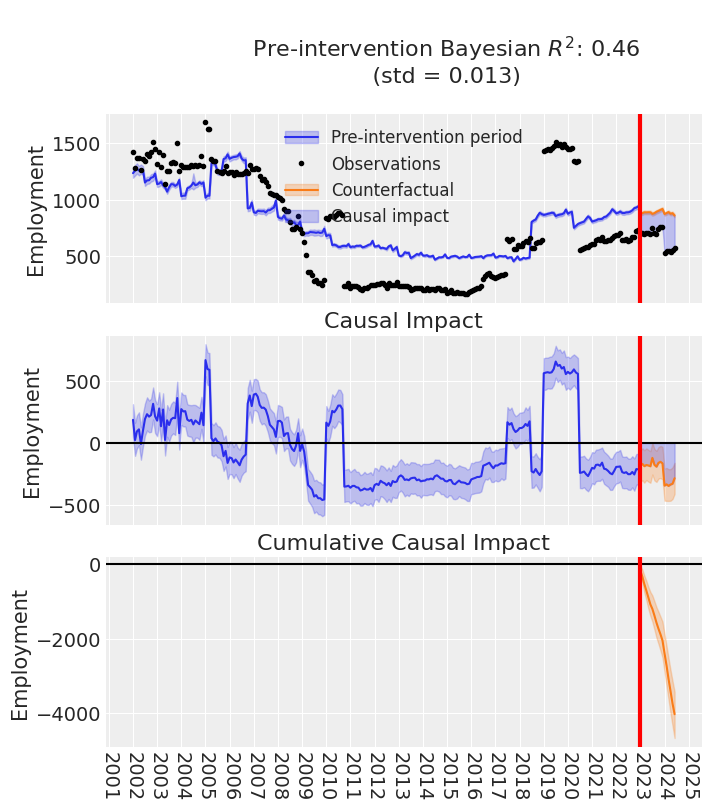

In [ ]:
fig, ax = result.plot(plot_predictors=False)
# INFO: I might be able to do it by county and see the effects on the changes by county

# formatting
ax[2].tick_params(axis="x", labelrotation=-90)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[2].xaxis.set_major_locator(mdates.YearLocator())
for i in [0, 1, 2]:
    ax[i].set(ylabel="Employment")

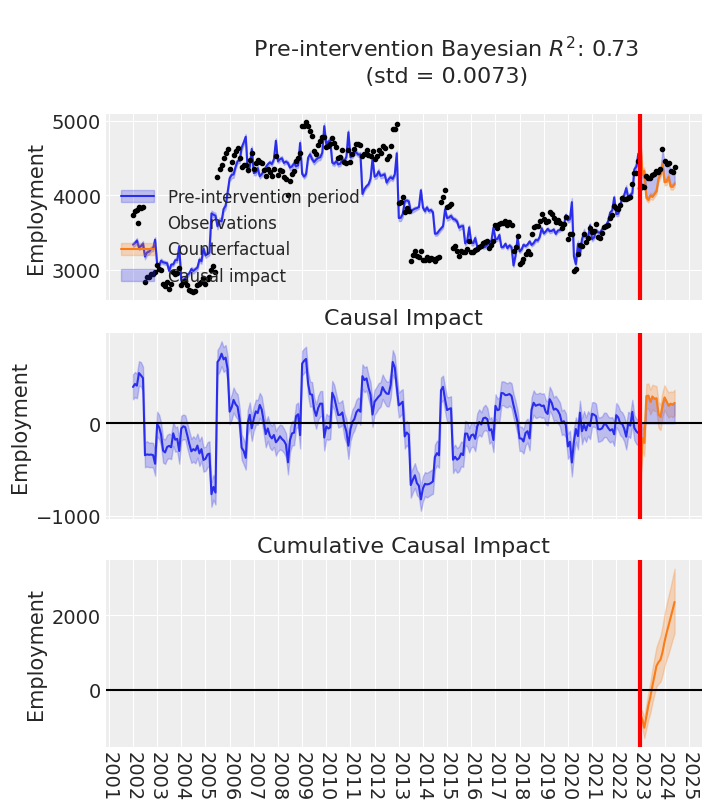

In [44]:
fig, ax = result.plot(plot_predictors=False)

# formatting
ax[2].tick_params(axis="x", labelrotation=-90)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[2].xaxis.set_major_locator(mdates.YearLocator())
for i in [0, 1, 2]:
    ax[i].set(ylabel="Employment")

In [ ]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)
df